In [1]:
# Reference Paper https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size =  3 #context length. How many characters do we take to predict the next one
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80% samples
Xdev, Ydev = build_dataset(words[n1:n2]) #10% samples
Xte, Yte = build_dataset(words[n2:]) #10% samples

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 10 # dimensions of character embedding vectors
n_hidden = 200 # number of nuerons in hidden layer

g = torch.Generator().manual_seed(2147483647) # for same result reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)
b2 = torch.randn(vocab_size, generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # FORWARD PASS
    emb = C[Xb] # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # First layer will be 3 input embeddings
    h = torch.tanh(hpreact) # Second (hidden) Layer (32, 100)
    logits = h @ W2 + b2 # Third Layer (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # print(loss.item())
    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}') #print once in a while
    lossi.append(loss.log10().item())

      0/ 200000:27.8817
  10000/ 200000:2.8263
  20000/ 200000:2.5130
  30000/ 200000:2.8010
  40000/ 200000:2.0541
  50000/ 200000:2.6152
  60000/ 200000:2.3549
  70000/ 200000:2.0835
  80000/ 200000:2.2652
  90000/ 200000:2.2635
 100000/ 200000:2.0810
 110000/ 200000:2.3367
 120000/ 200000:1.9650
 130000/ 200000:2.4398
 140000/ 200000:2.1524
 150000/ 200000:2.1201
 160000/ 200000:2.0399
 170000/ 200000:1.8172
 180000/ 200000:2.0771
 190000/ 200000:1.7632


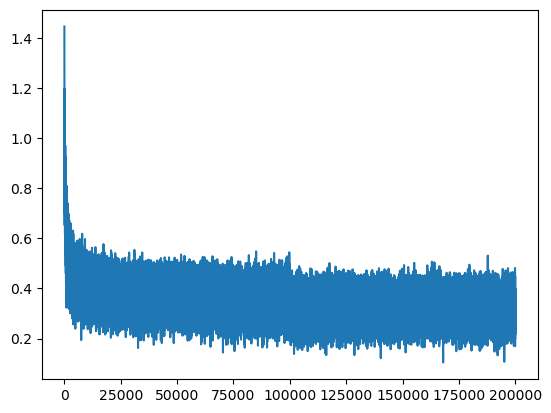

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1261181831359863
val 2.1693320274353027


In [10]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlah.
amorie.
khi.
myli.
taty.
salayson.
mahnen.
den.
art.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearynix.
kaelissuli.


In [11]:
# Problem 1: Loss at initialisation is very and should be close to 1/27 (because 27 chars) because we want each charater
# to have equal probablity at initialisation, Because of this problem model is spending time to bring loss in range of 1/27, which is bad.

#Solution: Decrease logits as much as possible in first iteration i.e reduce logits = h @ W2 + b2
# We can do this by setting 
# W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 (Weights will be very close to each other and prob will be almost equal and loss will be less) 
# and b2 = torch.randn(vocab_size, generator = g) * 0 at initialisation
n_embd = 10 # dimensions of character embedding vectors
n_hidden = 200 # number of nuerons in hidden layer

g = torch.Generator().manual_seed(2147483647) # for same result reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 # Changed
b2 = torch.randn(vocab_size, generator = g) * 0 # Changed

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [12]:
# Retraining
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # FORWARD PASS
    emb = C[Xb] # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # First layer will be 3 input embeddings
    h = torch.tanh(hpreact) # Second (hidden) Layer (32, 100)
    logits = h @ W2 + b2 # Third Layer (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # print(loss.item())
    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}') #print once in a while
    lossi.append(loss.log10().item())

# As we can see initial loss much lesser

      0/ 200000:3.3221
  10000/ 200000:2.1900
  20000/ 200000:2.4196
  30000/ 200000:2.6067
  40000/ 200000:2.0601
  50000/ 200000:2.4988
  60000/ 200000:2.3902
  70000/ 200000:2.1344
  80000/ 200000:2.3369
  90000/ 200000:2.1299
 100000/ 200000:1.8329
 110000/ 200000:2.2053
 120000/ 200000:1.8540
 130000/ 200000:2.4566
 140000/ 200000:2.1879
 150000/ 200000:2.1118
 160000/ 200000:1.8956
 170000/ 200000:1.8645
 180000/ 200000:2.0326
 190000/ 200000:1.8417


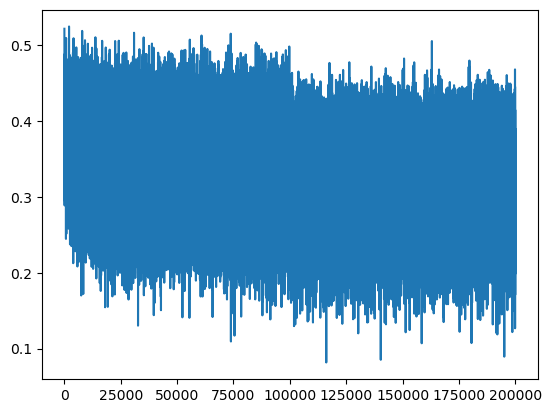

In [13]:
plt.plot(lossi)
# When we visualise it we see that the model takes time to train on more sensible values instead of bringing the loss down in range of 1/27

In [14]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695888996124268
val 2.131074905395508


In [15]:
# Problem 2: When calculating h = torch.tanh(hpreact), tanh squeeshes most of the values to 1 or -1 because of the way it works.
# Therefore, when backpropagating h and specifically the tanh function i.e 
#                                                self.grad += (1-t**2)*out.grad
# if t = 1 or t = -1, self.grad = 0. This is BAD because we are losing gradient. And in the forward pass, there are a lot of values
# that are 1 or -1

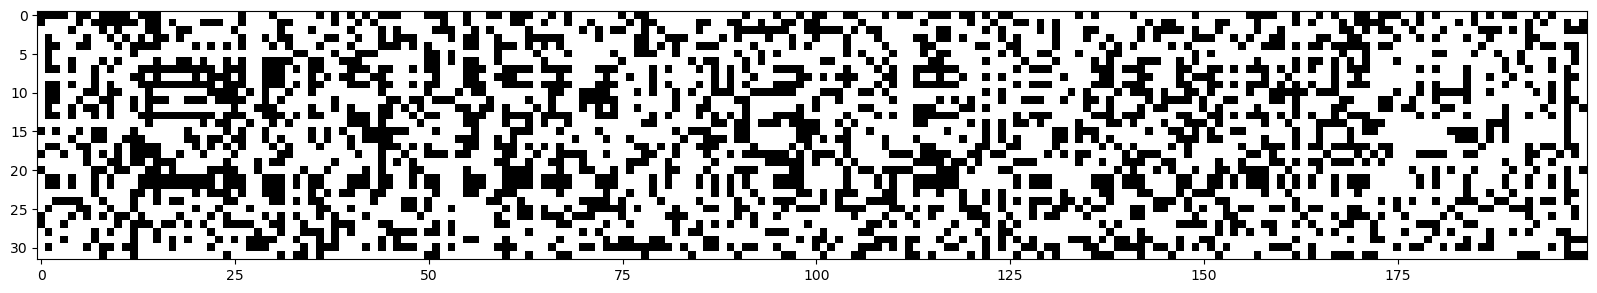

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

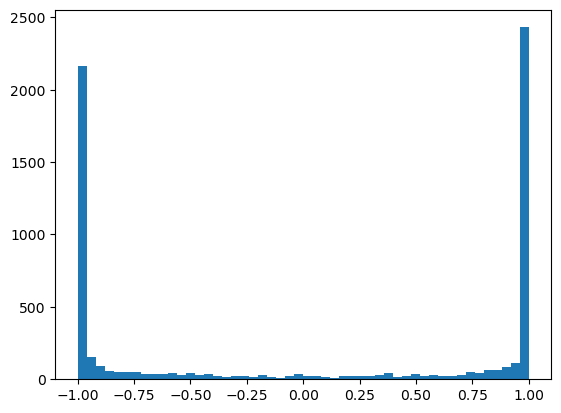

In [17]:
plt.hist(h.view(-1).tolist(), 50);

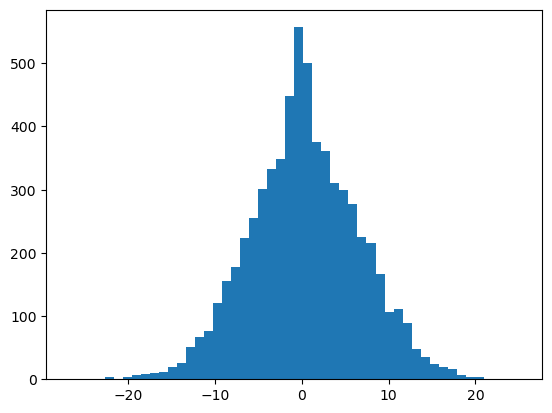

In [18]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [19]:
# Solution to problem 2: hpreact = embcat @ W1 + b1,
# embcat is uniform gaussian distribution so it is not causing this problem but W1 and b1 are not gaussian and are spread out.
# So, we multiply W1 and b1 with a small number (0.1 or 0.2 etc) to make them closer to zero
n_embd = 10 # dimensions of character embedding vectors
n_hidden = 200 # number of nuerons in hidden layer

g = torch.Generator().manual_seed(2147483647) # for same result reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * 0.2 # Changed
b1 = torch.randn(n_hidden, generator = g) * 0.01 # Changed
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [20]:
# Retraining
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # FORWARD PASS
    emb = C[Xb] # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # First layer will be 3 input embeddings
    h = torch.tanh(hpreact) # Second (hidden) Layer (32, 100)
    logits = h @ W2 + b2 # Third Layer (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # print(loss.item())
    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}') #print once in a while
    lossi.append(loss.log10().item())

# As we can see initial loss much lesser

      0/ 200000:3.3135
  10000/ 200000:2.1648
  20000/ 200000:2.3061
  30000/ 200000:2.4541
  40000/ 200000:1.9787
  50000/ 200000:2.2930
  60000/ 200000:2.4232
  70000/ 200000:2.0680
  80000/ 200000:2.3095
  90000/ 200000:2.1207
 100000/ 200000:1.8269
 110000/ 200000:2.2045
 120000/ 200000:1.9797
 130000/ 200000:2.3946
 140000/ 200000:2.1000
 150000/ 200000:2.1948
 160000/ 200000:1.8619
 170000/ 200000:1.7809
 180000/ 200000:1.9673
 190000/ 200000:1.8295


In [21]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.102678060531616


tensor(-0.0003) tensor(0.9953)
tensor(0.0026) tensor(3.1612)


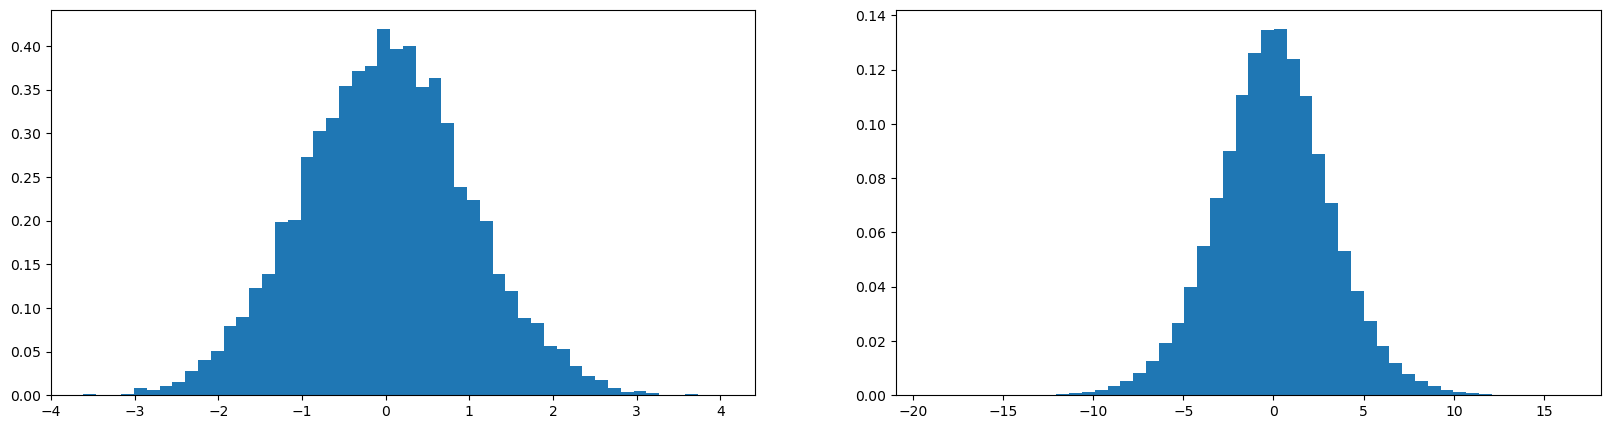

In [22]:
# How to find/calculate the magic numbers (like 0.2 or 0.01 in above case)
# Example Problem:
x = torch.randn(1000, 10) # Example random embeddings
w = torch.randn(10, 200) # Example random weights
y = x @ w # Pre-Activations
print(x.mean(), x.std()) # x's mean and standard deviation)
print(y.mean(), y.std()) # y's mean and standard deviation)
# Standard deviation basically means the spread/expansion of data/value as compared to mean
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [23]:
# After plotting we can see that y is more spread out than x.
# THIS IS BAD as we want ROUGHLY UNIT GAUSSIAN across the network
# TO FIND: How to scale w to preserve unit gaussian
# For example: If
x = torch.randn(1000, 10) 
w = torch.randn(10, 200) * 5 # This will increase the spread

y = x @ w # Pre-Activations
print(x.mean(), x.std()) # x's mean and standard deviation)
print(y.mean(), y.std()) # y's mean and standard deviation)

w = torch.randn(10, 200) * 0.2 # This will decrease the spread
y = x @ w # Pre-Activations

print(x.mean(), x.std()) # x's mean and standard deviation)
print(y.mean(), y.std()) # y's mean and standard deviation)

tensor(-0.0028) tensor(1.0072)
tensor(-0.0620) tensor(16.0345)
tensor(-0.0028) tensor(1.0072)
tensor(-0.0008) tensor(0.6357)


In [24]:
# Now we need to find what to multiply to preserve STD =~ 1.
# Mathematically it is found that we are supposed to divide weights by square root of 'Fan N'
# Fan n = number of input elements i.e 10 in this case
# Therefore,
# w = torch.randn(10, 200) / 10**0.5
# Raising a number by 0.5 is equal to it's square root
# So,
x = torch.randn(1000, 10) 
w = torch.randn(10, 200) / 10**0.5

y = x @ w # Pre-Activations
print(x.mean(), x.std()) # x's mean and standard deviation)
print(y.mean(), y.std()) # y's mean and standard deviation)
 # We find that std of y is close to 1 i.e UNIT GAUSSIAN

tensor(-0.0015) tensor(0.9984)
tensor(-0.0011) tensor(1.0192)


In [25]:
# In MLP's if the network is big we need to make sure that the activations are well behaved i.e they are not 
# squaushing down to 0 or raising upto infinity at initialisation.
# This was focused on in paper https://arxiv.org/abs/1502.01852
# This paper also focuses on the std of backpropagated gradients.
# This paper introduces that to make the std gaussian:
#                   std = gain/fan_mode**0.5
# Gain: Because tanh, ReLU etc are squashing operations, to make sure that std stays consistent, we need to boost the output 
# distributions with some number to ensure Unit Gaussian
# For example for ReLU gain is 2**0.5 because ReLU sqaushes half inputs to zero.
# Similarly for tanh is it 5/3
# Details for all https://pytorch.org/docs/stable/nn.init.html
# This appraoch was also implemented in Pytorch in torch.nn.init.kaiming_normal()
# So while initialising our nueral net we need to: 

n_embd = 10 # dimensions of character embedding vectors
n_hidden = 200 # number of nuerons in hidden layer

g = torch.Generator().manual_seed(2147483647) # for same result reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size)**0.5) #According to the proposed paper
b1 = torch.randn(n_hidden, generator = g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [26]:
# Retraining
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # FORWARD PASS
    emb = C[Xb] # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # First layer will be 3 input embeddings
    h = torch.tanh(hpreact) # Second (hidden) Layer (32, 100)
    logits = h @ W2 + b2 # Third Layer (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # print(loss.item())
    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}') #print once in a while
    lossi.append(loss.log10().item())

# As we can see initial loss is lesser 

      0/ 200000:3.3179
  10000/ 200000:2.1910
  20000/ 200000:2.3270
  30000/ 200000:2.5396
  40000/ 200000:1.9468
  50000/ 200000:2.3331
  60000/ 200000:2.3852
  70000/ 200000:2.1173
  80000/ 200000:2.3159
  90000/ 200000:2.2010
 100000/ 200000:1.8591
 110000/ 200000:2.0881
 120000/ 200000:1.9389
 130000/ 200000:2.3913
 140000/ 200000:2.0949
 150000/ 200000:2.1458
 160000/ 200000:1.7824
 170000/ 200000:1.7249
 180000/ 200000:1.9752
 190000/ 200000:1.8614


In [27]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
# Similar results with much more scalable initialisation

train 2.0376641750335693
val 2.106989622116089


In [28]:
# BATCH NORMALISATION: (40:35)
# This was a technique introduced by google in paper https://arxiv.org/abs/2105.07576
# They introduced that in order to make our activations gaussian, we can just take our pre activation and simply make them gaussian
# This was a very simple and effective technique. On top of that it works because this operation is perfectly diffrentiable as well.
# Why do we want pre activations to be gaussian? Because if they are very small numbers then the tanh is inactve and if they are 
# very large then tanh is very saturated
# What the paper introduced:
# 1. Calculate the mean i.e
#              m = sum of all values/ total number of values
# 2. Calculate the variance i.e
#          variance = (standard_deviatiaon)**2 = (element - mean)**2/total number of elements      (This signifies how away a value is from the mean)
# 3. Calculate standard deviation i.e
#          standard_deviatiaon = square root of variance     # THis will normalise the data
# 4. Scale and shift i.e
#          y = (gain * standard_deviatiaon) + bias   # This will normalise the data throughout the model

n_embd = 10 # dimensions of character embedding vectors
n_hidden = 200 # number of nuerons in hidden layer

g = torch.Generator().manual_seed(2147483647) # for same result reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size)**0.5) #According to the proposed paper
b1 = torch.randn(n_hidden, generator = g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

bngain = torch.ones((1, n_hidden)) # Batch normalisation gain
bnbias = torch.ones((1, n_hidden)) # Batch normalisation bias

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [29]:
# Retraining
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # FORWARD PASS
    emb = C[Xb] # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Applying the approach mentioned in paper i.e Batch Normalisation
    # Because bngain is initialised to 1 and bnbias is initialised to zero, the pre activation at least at initialisation will be roughly gaussian
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias 
    
    # First layer will be 3 input embeddings
    h = torch.tanh(hpreact) # Second (hidden) Layer (32, 100)
    logits = h @ W2 + b2 # Third Layer (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # print(loss.item())
    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}') #print once in a while
    lossi.append(loss.log10().item())

# As we can see initial loss is lesser 

      0/ 200000:3.3401
  10000/ 200000:2.2846
  20000/ 200000:2.3284
  30000/ 200000:2.5253
  40000/ 200000:1.9592
  50000/ 200000:2.5090
  60000/ 200000:2.3124
  70000/ 200000:2.0885
  80000/ 200000:2.3997
  90000/ 200000:2.1687
 100000/ 200000:1.9234
 110000/ 200000:2.3111
 120000/ 200000:1.9855
 130000/ 200000:2.5203
 140000/ 200000:2.3358
 150000/ 200000:2.2478
 160000/ 200000:2.0123
 170000/ 200000:1.8866
 180000/ 200000:1.9666
 190000/ 200000:1.8665


In [30]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # Included here as well
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
# Similar results with much more scalable initialisation

train 2.0668179988861084
val 2.11177921295166


In [31]:
# As this is a small NN, we are not expecting the batch norm layer to make a huge difference. But as the NN size
# grows, it becomes really hard to make weight matrices roughly gaussian. So in that case it becomes handy to apply
# batch norm layer acroos the network after every pre activation layer (Basically after layers where matrix mul is taking place).

In [32]:
# Now what was traditionally done that we used to feed to one input example in the NN and it used to give us it's logits as output.
# But for efficiency reasons we decided to pass input as a batch(as in the example above)
# So what effect this has is that the each input example has some value of mean and STD that are present in the batch as well.
# Astonishingly, this somehow has a good effect on the performance. This is because NN learns to pad out the additional entropy that 
# other examples in the batch bring along. All this makes it harder for NN to OVERFIT the data and therefore enhances the performance.
# This has somewhat an affect similar to Data augumentation.
# Batch Normalisation has a regularisation effect that makes it even better (52:00)

In [33]:
"""
Right now the NN is taking a batch of 3 and producing result based on that. What if we need to input one example and get result for that one 
input?
The paper suggested that we calculate the Mean and STD for the entire training set once before training. This will have fixed mean and std.
That means fixed numbers.
Then instead of calculating the hpreact, we calculate it based on pre caluculated values.
"""

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
bnmean, bnstd

(tensor([[-2.2830e-03,  2.3314e-04, -1.7935e+00,  3.9475e-01, -1.2088e+00,
           8.8940e-01,  1.9944e+00,  1.7648e+00,  7.8241e-01,  2.2918e+00,
          -2.2332e+00, -2.2610e+00, -8.9849e-01, -7.7208e-01, -5.9051e-01,
           1.5853e+00,  3.0194e-01, -2.0090e+00, -1.1314e+00,  1.3202e+00,
           9.6731e-01, -1.0198e+00,  9.5860e-01,  4.1243e-01,  9.6788e-01,
           7.1672e-01,  6.9090e-01, -1.8534e+00,  3.5037e-01,  1.3999e+00,
          -3.8203e-01, -1.9591e+00, -1.2362e+00, -2.0290e-01, -1.2511e+00,
          -1.5688e+00, -2.2653e+00, -6.1519e-01,  1.4280e-01, -3.1523e-01,
           2.2841e-01, -4.5146e-01, -1.0894e+00, -2.0975e-01,  1.6558e+00,
           2.8455e-01, -5.9375e-01, -1.3964e+00,  1.1942e+00,  1.6368e+00,
           6.3895e-01,  1.1443e+00,  2.1573e+00, -2.0217e-01,  1.2154e+00,
          -1.7685e+00, -8.3350e-01,  8.9619e-01,  7.5470e-01, -6.1893e-01,
          -1.6283e+00, -2.6783e-01, -9.2841e-01, -5.9752e-01,  7.1627e-02,
          -4.8202e-01,  9

In [34]:
bnmean.shape, bnstd.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [35]:
# Retraining
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # FORWARD PASS
    emb = C[Xb] # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    # Applying the approach mentioned in paper i.e Batch Normalisation
    # Because bngain is initialised to 1 and bnbias is initialised to zero, the pre activation at least at initialisation will be roughly gaussian

    # Because bnmean and bnstd are fixed, the bnmean and bnstd is not based on the whole input batch of 3 as compared to before
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias #Pre calculated mean and std)
    
    # First layer will be 3 input embeddings
    h = torch.tanh(hpreact) # Second (hidden) Layer (32, 100)
    logits = h @ W2 + b2 # Third Layer (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # print(loss.item())
    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}') #print once in a while
    lossi.append(loss.log10().item())

# We gain amost identical results

      0/ 200000:2.2764
  10000/ 200000:1.8187
  20000/ 200000:2.4479
  30000/ 200000:2.5470
  40000/ 200000:2.2148
  50000/ 200000:2.3033
  60000/ 200000:2.1588
  70000/ 200000:1.7862
  80000/ 200000:2.1813
  90000/ 200000:2.2586
 100000/ 200000:1.8994
 110000/ 200000:1.9739
 120000/ 200000:2.0319
 130000/ 200000:2.3274
 140000/ 200000:1.9915
 150000/ 200000:2.3165
 160000/ 200000:2.2231
 170000/ 200000:2.0658
 180000/ 200000:1.9055
 190000/ 200000:2.1765


In [54]:
'''
But no one wants to calculate Mean and STD as a second stage. Therefore the paper introduced another way to do so in a RUNNING MANNER.

Approach:
1. Before trinaining Initialise bnmean_running = torch.zeros((1, n_hidden)) #Because at initialisation the roughly gaussian mean will be around 0
2. Before trinaining Initialise bnstd_running = torch.ones((1, n_hidden)) #Because at initialisation the roughly gaussian std will be around 1
3. During training calculate mean and std for current i,
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
4. After hpreact calculation, update bnmean_running and bnstd_running a little bit in the direction of bnmeani and bnstdi,
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    This step won't require us to calculate gradients as we are already updating bnmean_running and bnstd_running on the side while training
    the NN.
'''
n_embd = 10 # dimensions of character embedding vectors
n_hidden = 200 # number of nuerons in hidden layer

g = torch.Generator().manual_seed(2147483647) # for same result reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size)**0.5) #According to the proposed paper

# Removing b1 because it is getting subtracted in hpreact anyway. Instead we are using bnbias which is responsible for biasing
#b1 = torch.randn(n_hidden, generator = g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

bngain = torch.ones((1, n_hidden)) # Batch normalisation gain
bnbias = torch.ones((1, n_hidden)) # Batch normalisation bias

bnmean_running = torch.zeros((1, n_hidden)) # For running mean
bnstd_running = torch.ones((1, n_hidden)) # For Running std

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [55]:
# Retraining
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # FORWARD PASS
    emb = C[Xb] # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation (removing bias because it is getting subtracting in hpreact anyways)

    # Applying the approach mentioned in paper i.e Batch Normalisation
    # Because bngain is initialised to 1 and bnbias is initialised to zero, the pre activation at least at initialisation will be roughly gaussian
    
    bnmeani = hpreact.mean(0, keepdim=True) # Mean of current i
    bnstdi = hpreact.std(0, keepdim=True) # STD of current i
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias 

    # Updating the bnmean_running and bnstd_running in the direction of bnmeani and bnstdi while training but on the side
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # First layer will be 3 input embeddings
    h = torch.tanh(hpreact) # Second (hidden) Layer (32, 100)
    logits = h @ W2 + b2 # Third Layer (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}') #print once in a while
    lossi.append(loss.log10().item())
    # Similar results

      0/ 200000:3.3056
  10000/ 200000:1.9817
  20000/ 200000:2.6418
  30000/ 200000:2.0012
  40000/ 200000:2.3115
  50000/ 200000:1.8987
  60000/ 200000:2.0529
  70000/ 200000:2.3327
  80000/ 200000:2.4092
  90000/ 200000:2.2383
 100000/ 200000:2.2589
 110000/ 200000:2.2823
 120000/ 200000:1.6926
 130000/ 200000:1.9830
 140000/ 200000:2.2002
 150000/ 200000:2.0063
 160000/ 200000:1.9524
 170000/ 200000:2.4093
 180000/ 200000:2.1574
 190000/ 200000:2.2078


In [56]:
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [57]:
# Now if we compare the Pre calculated mean and std with running mean and std, we will find that they are not very different
bnmean_running, bnmean

(tensor([[-0.2917, -0.2343, -1.9383,  0.8034, -1.0933,  0.7949,  2.3547,  2.0389,
           0.7187,  2.2388, -2.3641, -2.6146, -0.1790, -1.1427, -0.4775,  1.2726,
           0.3743, -2.3318, -0.8128,  1.9031,  1.5286, -1.4091,  0.6030,  0.6167,
           0.6414,  0.7220,  0.5056, -1.4201,  0.0679,  1.2839, -0.4748, -2.0299,
          -1.3055, -0.3203, -1.5839, -1.1478, -2.3263, -0.3068,  0.4754, -0.2273,
           0.0083, -0.6261, -1.0910, -0.4189,  0.5433,  0.2222, -0.7673, -1.3299,
           0.9662,  1.8995, -0.1890,  1.1271,  1.5915, -0.7239,  0.7229, -2.2161,
          -1.0499,  0.8685,  0.7098, -0.7499, -1.7031, -0.0340, -0.2502, -1.0810,
          -0.0141,  0.0455,  0.2386,  0.4491, -0.2106, -0.0111, -0.9167,  0.2827,
           1.2227, -0.9292, -2.0393, -0.3026,  1.2478,  0.5243,  0.7493,  0.4667,
           0.8211,  1.2614,  0.4847, -0.8418,  1.3152, -1.0063, -1.2195, -1.0395,
           0.0413, -1.3459, -1.1031,  1.2771, -0.8002, -0.4052, -0.7601, -1.0168,
          -0.360

In [58]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # Included here as well
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
# Similar results to precalculated Mean and STD

train 2.066295623779297
val 2.111121416091919


In [60]:
# The paper also recommended to add 'epsilon' with STD while calculating hpreact. 
# Epsilon is a fixed small number that prevents division by 0.
# As our network is fairly small, we won't be needing epslon as of now
# Real world example of the NN that we implemented is resnet and pytorch's Linear layer and BatchNorm2d layer (01:04:55)

In [ ]:
# Let's Pytorch-ify our code in a way that we will encounter in Real world examples
